In [1]:
%matplotlib inline

from perf_plotter import get_filtered_data, flatten, get_diffs, __compare, rgetattr
import data_parser
import argparse
import plot_styles as ps
from plot_styles import wheeler, marker_wheel, color_wheel
import matplotlib.pyplot as plt
import general_plotting as gp
import numpy as np
import os
import pickle
from optionloop import OptionLoop
from collections import defaultdict
import six

In [2]:
run = data_parser.run
rundata = data_parser.rundata
data = None
try:
    with open(os.path.join('.', 'data.pickle'), 'rb') as file:
        data = pickle.load(file)
except:
    pass
finally:
    if data is None:
        data = data_parser.parse_data()
        with open(os.path.join('.', 'data.pickle'), 'wb') as file:
            pickle.dump(data, file)
            
mechs = data.keys()

In [3]:
def separate(data, plot_type='runtime', norm=True, plot_scaling=False, **pwkwds):
    diffs, locs, check = get_diffs(flatten(data))
    if plot_scaling:
        diffs.append(set(data.keys()))
        locs.append(-1)
        check.append('mechdata.name')
    oploop = OptionLoop({check[locs[i]]: list(diffs[i]) for i in range(len(locs))})
    rv = []
    for state in oploop:
        subdata = get_filtered_data(data, warn=False, strict=True, **state)
        subdata = flatten(subdata)
        if not subdata:
            continue
        x, y, z = gp.process_data(subdata, plot_type, plot_scaling=plot_scaling, **pwkwds)
        # get the part of the subdata that is identical across all for later ident.
        sd, _, sc = get_diffs(subdata)
        # and store
        same = {c: rgetattr(subdata[0], c) for c in sc if sc not in sd}
        if plot_scaling:
            same['mechdata.name'] = state['mechdata.name']
        rv.append((same, (np.array(x), np.array(y), np.array(z)), subdata))
    return rv

In [4]:
def combine(datalist):
    combined = defaultdict(lambda: [])
    for data in datalist:
        for mech in data:
            combined[mech].extend(data[mech])

    return combined

In [5]:
class normalizer(object):
    def __init__(self, key):
        self.ymax = defaultdict(lambda: None)
        self.key = key
    
    def __getitem__(self, state):
        if self.key is None:
            return self.ymax['default']
        return self.ymax[state[self.key]]

    def __setitem__(self, state, value):
        if self.key is None:
            self.ymax['default'] = value
        else:
            self.ymax[state[self.key]] = value

In [6]:
def normalize_per_key(data, key):
    # normalize pre-separated data per a given key in the data
    # first pass -- get y max per x
    ymax = normalizer(key)
    for state, (x, y, z), _ in data:
        if ymax[state] is None:
            ymax[state] = y[:]
        ymax[state] = np.maximum(y, ymax[state])
        
    # second pass -- normalize y & z
    for i in range(len(data)):
        state = data[i][0]
        x, y, z = data[i][1]
        z = (z / y) * (ymax[state] / y)
        y = ymax[state] / y
        data[i] = (state, (x, y, z), data[i][2])
   
    return data

In [7]:
def normalize_per_mech(data):
    # normalize pre-separated data per mechanism
    return normalize_per_key(data, None)

In [8]:
def plot(data, namefunc, markerfunc, norm=None, plot_scaling=False):
    sep = separate(data, plot_scaling=plot_scaling)
    if norm is not None:
        sep = norm(sep)
    plot_ind = 0
    for state, subdata, _  in sep:
        gp.plot(*subdata, label=namefunc(state), marker=markerfunc(state), plot_ind=plot_ind)
        plot_ind +=1

In [9]:
def pretty_name(state, key):
    return ps.pretty_names(key).format(state[key])

In [10]:
def finalize_plot(ylog=None, xlog=None, limits={}, labels={}):
    plt.xlabel(labels['x'])
    plt.ylabel(labels['y'])
    plt.title(labels['title'])
    if 'x' in limits:
        plt.gca().set_xlim(limits['x'])
    if 'y' in limits:
        plt.gca().set_ylim(limits['y'])
    if ylog:
        plt.gca().set_yscale('log')
    if xlog:
        plt.gca().set_xscale('log')
    plt.legend(loc=0)
    ps.finalize()
    plt.show()

In [11]:
def plot_data_standard(data, namefunc, marker_func, labels, ylog=False, xlog=False,
                       limits={}, norm=None, filter_num_conditions=None, **pwargs):
    if filter_num_conditions is not None:
        data = filter_num_conditions(data)
    plot(data, namefunc, marker_func, norm=norm, **pwargs)
    finalize_plot(ylog=ylog, xlog=xlog, limits=limits, labels=labels)

In [12]:
def plot_data_gpu_standard(*args, **kwargs):
    def max_num_conds_filter(data):
        for mech in data:
            max_num_cond = max([max(r.num_conditions for r in d.rundata) for d in data[mech]])
            for i in range(len(data[mech])):
                copy = data[mech][i].copy()
                data[mech][i] = copy._replace(
                    rundata=[r for r in copy.rundata if r.num_conditions == max_num_cond])
        return data
    plot_data_standard(*args, filter_num_conditions=max_num_conds_filter, **kwargs)

In [13]:
# parameter orderings -- to ensure the legend always contains the same
# parameter -> symbol / color mapping
vectype_order = ['w', 'd', 'par', 'openmp']
descriptor_order = ['haswell', 'srv2']
gpu_desc_order = ['gpu', 'srv2-gpu']
vecwidth_order = ['4', '8', '16']
gpu_vecwidth_order = ['64', '128']
conp_order = ['conp', 'conv']
data_order = ['C', 'F']
mech_order = ['H2', 'CH4', 'C2H4', 'IC5H11OH']

# common labels
reac_label = r'Runtime (\si{\milli\second} / state)'
speedup_label = r'Speedup'
runtime_label = r'Runtime (\si{\milli\second} / state)'

def name_order(param_list):
    return sorted(param_list, key=lambda x: run._fields.index(key))

In [14]:
class recursive_dict(object):
    def __init__(self, key, value_list, return_index=True):
        self.key = key
        self.value_list = None
        if value_list is not None:
            self.value_list = value_list.copy()
        self.return_index = return_index
        
    def __call__(self, state, **kwargs):
        key = self.key
        if 'key' in kwargs:
            key = kwargs.pop('key')
        values = self.value_list
        if 'values' in kwargs:
            values = kwargs.pop('values')
        if values is None:
            # no value list ->
            return key
        if isinstance(values, dict):
            # recursively defined
            k, v = values[state[key]]
            return self.__call__(state, key=k, values=v)
        if self.return_index:
            # if we want the index
            return values.index(state[key])
        # else the value
        return values[values.index(state[key])]

class marker_dict(object):
    def __init__(self, color_key, color_dict, marker_key, marker_dict):
        self.color_dict = recursive_dict(color_key, color_dict)
        self.color_wheel = wheeler(color_wheel)
            
        self.marker_dict = recursive_dict(marker_key, marker_dict)
        self.marker_wheel = wheeler(marker_wheel)
        
    def __getcolor__(self, state):
        return self.color_wheel[self.color_dict(state)]
    
    def __getmarker__(self, state, marker_key=None, marker_list=None):
        return self.marker_wheel[self.marker_dict(state)]
    
    def __call__(self, state):
        marker, hollow = self.__getmarker__(state)
        return marker, hollow, self.__getcolor__(state)

In [15]:
class compound_namer(object):
    def __normalize(self, kvdict):
        outdict = kvdict.copy()
        for key, values in kvdict.items():
            if values is not None:
                # now, for each new kv pair, ensure we have a further dictionary
                if isinstance(values, dict):
                    # recursively normalize
                    outdict[key] = self.__normalize(values)
                else:
                    # or a (key, None) tuple
                    outdict[key] = (values, None)
        return outdict

    def __init__(self, **kvlist):
        self.keys = []
        for key, values in self.__normalize(kvlist).items():
            self.keys.append(recursive_dict(key, values, False))
                    
    
    def add_key(self, state, key):
        return  pretty_name(state, key(state))
            
    def add_keys(self, state):
        name = ''
        for key in self.keys:
            if name:
                name += ' - '
            name += self.add_key(state, key)
        return name
    
    def __call__(self, state):
        return self.add_keys(state)

In [16]:
class default_filters(object):
    def __init__(self, **filters):
        self.filters = dict(platform=lambda x: True,
                       lang=lambda x: True,
                       vectype=lambda x: True,
                       cores='1',
                       conp='conp',
                       order=lambda x: True,
                       vecwidth=lambda x: True,
                       descriptor=lambda x: True,
                       rates='hybrid')
        self.filters.update(filters)
    
    def __add__(self, other):
        newfilt = self.filters.copy()
        newfilt.update(other)
        return default_filters(**newfilt)

def get_filters(lang='opencl', cpu=True, vecwidth='8', source=True):
    base = default_filters()
    if lang == 'opencl':
        base += {'lang': 'opencl', 'vecwidth': vecwidth}
    elif lang == 'c':
        base += {'lang': 'c', 'vectype': 'openmp'}
    if cpu is not None:
        base += {'order': ('C' if cpu else 'F')}
    if source is not None:
        base += {'rtype': ('spec' if source else 'jac')}
        if not source:
            base += {'sparse': 'sparse'}
    return base

def get_filtered(base=None, **filters):
    base = (base or default_filters()) + filters
    return get_filtered_data(data, **base.filters)

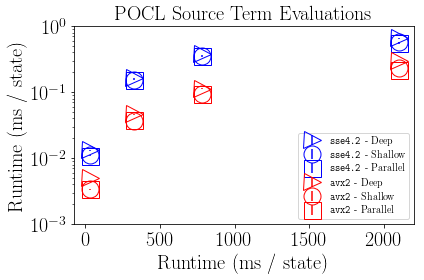

In [17]:
# begin source term plots
#1 POCL equivalency over all type

filtered = get_filtered(
    get_filters(),
    platform='portable',
    descriptor=lambda x: x in ['srv2', 'haswell'])

namer = compound_namer(descriptor=None, vectype=None)
marker = marker_dict('descriptor', descriptor_order,
                     'vectype', vectype_order)

plot_data_standard(filtered, namer, marker, {
    'x': reac_label,
    'y': runtime_label,
    'title': 'POCL Source Term Evaluations'},
    ylog=True,
    limits={'y': [1e-3, 1e0]})

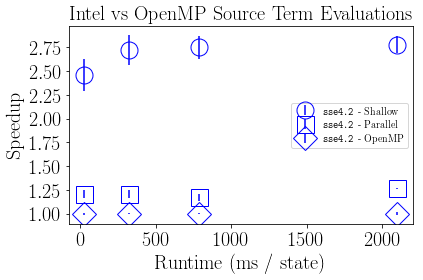

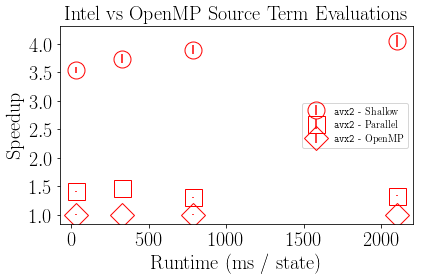

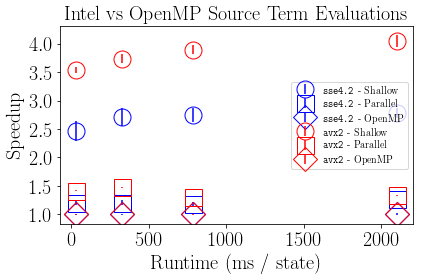

In [18]:
# next intel vs OpenMP

def __get_data(desc):
    return combine([get_filtered(
                       get_filters(),
                       platform='intel',
                       vectype=lambda x: x in ['w', 'par'],
                       descriptor=lambda x: x in desc),
                    get_filtered(
                       get_filters(lang='c'),
                       descriptor=lambda x: x in desc)
                   ])

namer = compound_namer(descriptor=None,
                       vectype)
marker = marker_dict(
    'descriptor', descriptor_order,
    'vectype', vectype_order
    )

plot_data_standard(__get_data(['srv2']), namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=normalize_per_mech)

plot_data_standard(__get_data(['haswell']), namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=normalize_per_mech)

plot_data_standard(__get_data(['haswell', 'srv2']), namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=lambda data: normalize_per_key(data, 'descriptor'))

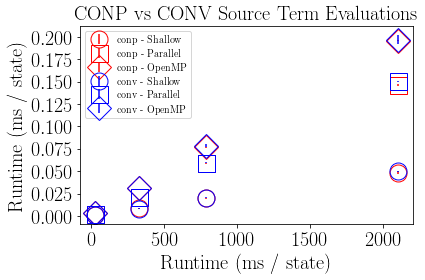

In [19]:
# conp vs conv
filtered = combine([get_filtered(
                        get_filters(),
                        platform='intel',
                        conp=lambda x: True,
                        descriptor='haswell'),
                    get_filtered(
                        get_filters(lang='c'),
                        conp=lambda x: True,
                        descriptor='haswell')])
        

namer = compound_namer(conp=None, vectype=None)
marker = marker_dict(
    'conp', conp_order,
    'vectype', vectype_order)


plot_data_standard(filtered, namer, marker, {
    'x': reac_label,
    'y': runtime_label,
    'title': 'CONP vs CONV Source Term Evaluations'})

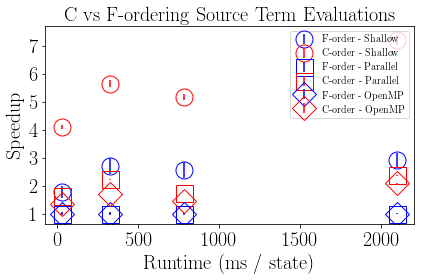

In [20]:
# C vs F on cpu
filtered = combine([get_filtered(
                        get_filters(),
                        platform='intel',
                        descriptor='haswell',
                        order='C'),
                    get_filtered(
                        get_filters(),
                        platform='intel',
                        descriptor='haswell',
                        order='F'),
                     get_filtered(
                        get_filters(lang='c'),
                        descriptor='haswell',
                        order='C'),
                    get_filtered(
                        get_filters(lang='c'),
                        descriptor='haswell',
                        order='F')])
        

namer = compound_namer(order=None, vectype=None)
marker = marker_dict(
    'order', data_order,
    'vectype', vectype_order)


plot_data_standard(filtered, namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'C vs F-ordering Source Term Evaluations'},
    norm=lambda data: normalize_per_key(data, 'lang'))

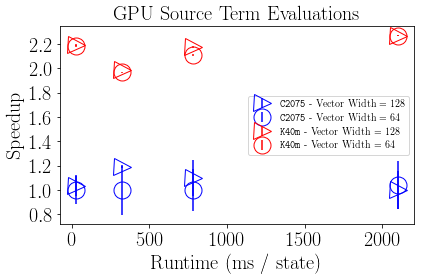

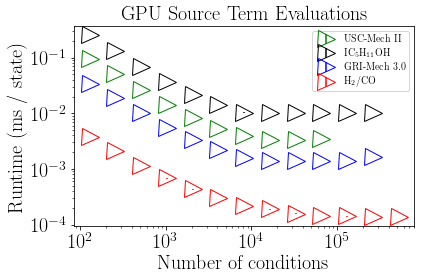

In [21]:
# NVIDIA
def __get_data(desc=['srv2-gpu', 'gpu'], vw=['64', '128']):
    return get_filtered(
        get_filters(cpu=False),
        platform='nvidia',
        descriptor=lambda x: x in desc,
        vecwidth=lambda x: x in vw,
        order='F',
        vectype='w')

namer = compound_namer(descriptor=None, vecwidth=None)
marker = marker_dict('descriptor', gpu_desc_order,
                     'vecwidth', gpu_vecwidth_order)


plot_data_gpu_standard(__get_data(), namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'GPU Source Term Evaluations'},
    norm=normalize_per_mech)

namer = compound_namer(**{'mechdata.name': None})
marker = marker_dict('mechdata.name', mech_order,
                     'vecwidth', gpu_vecwidth_order)

plot_data_standard(__get_data(desc=['gpu'], vw=['128']), namer, marker, {
    'x': 'Number of conditions',
    'y': runtime_label,
    'title': 'GPU Source Term Evaluations'},
    plot_scaling=True,
    ylog=True,
    xlog=True)

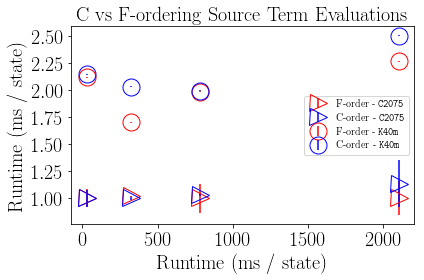

In [37]:
# C vs F on GPU
filtered = combine([get_filtered(
                        get_filters(cpu=False),
                        descriptor=lambda x: 'gpu' in x,
                        order='C',
                        vecwidth='128'),
                    get_filtered(
                        get_filters(cpu=False),
                        descriptor=lambda x: 'gpu' in x,
                        vecwidth='128',
                        order='F')])
        
namer = compound_namer(order=None, descriptor=None)
marker = marker_dict(
    'order', data_order,
    'descriptor', gpu_desc_order)


plot_data_gpu_standard(filtered, namer, marker, {
    'x': reac_label,
    'y': runtime_label,
    'title': 'C vs F-ordering Source Term Evaluations'},
    norm=normalize_per_mech)

In [ ]:
# next intel vs OpenMP
def __get_data(desc):
    return combine([get_filtered(
                       get_filters(source=False),
                       platform='intel',
                       vectype=lambda x: x in ['w', 'par'],
                       descriptor=lambda x: x in desc,
                       printf=True),
                    get_filtered(
                       get_filters(source=False, lang='c'),
                       descriptor=lambda x: x in desc)
                   ])

namer = compound_namer(descriptor=None,
                       vectype=None)
marker = marker_dict(
    'descriptor', descriptor_order,
    'vectype', vectype_order
    )


plot_data_standard(__get_data(['srv2']), namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=normalize_per_mech)

plot_data_standard(__get_data(['haswell']), namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=normalize_per_mech)

plot_data_standard(__get_data(['haswell', 'srv2']), namer, marker, {
    'x': reac_label,
    'y': speedup_label,
    'title': 'Intel vs OpenMP Source Term Evaluations'},
                   norm=lambda data: normalize_per_key(data, 'descriptor'))